In [1]:
import tensorflow as tf

# Sprawdzenie dostępności GPU
physical_devices = tf.config.list_physical_devices('GPU')
print("Dostępne urządzenia GPU:", physical_devices)

# Sprawdzenie wersji TensorFlow
print("Wersja TensorFlow:", tf.__version__)

# Jeśli GPU nie jest dostępne, wypisujemy szczegóły
if not physical_devices:
    print("Brak dostępnych urządzeń GPU. Sprawdź, czy masz poprawnie zainstalowane CUDA i cuDNN.")
else:
    # Jeśli GPU jest dostępne, próbujemy ustawić pamięć dynamiczną
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Pamięć dla GPU ustawiona na dynamiczną.")

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Source - https://stackoverflow.com/a
# Posted by adelriosantiago, modified by community. See post 'Timeline' for change history
# Retrieved 2025-11-26, License - CC BY-SA 4.0

from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

# Your output is probably something like ['/device:CPU:0']
# It should be ['/device:CPU:0', '/device:GPU:0']



Dostępne urządzenia GPU: []
Wersja TensorFlow: 2.12.0
Brak dostępnych urządzeń GPU. Sprawdź, czy masz poprawnie zainstalowane CUDA i cuDNN.
Num GPUs Available:  0
['/device:CPU:0']


In [2]:

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [3]:
# Ścieżka do głównego folderu z danymi
base_dir = r"C:\Users\matik\Documents\Data Sets\Faulty_solar_panel"

# Przygotowanie generatorów danych (treningowych i walidacyjnych)
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    base_dir, 
    target_size=(224, 224),  # Rozmiar wejściowy dla ResNet50
    batch_size=32,
    class_mode='categorical',  # Klasyfikacja wieloklasowa
    subset='training'  # Używamy 80% danych do treningu
)

valid_gen = datagen.flow_from_directory(
    base_dir, 
    target_size=(224, 224),  # Rozmiar wejściowy dla ResNet50
    batch_size=32,
    class_mode='categorical',  # Klasyfikacja wieloklasowa
    subset='validation'  # Używamy 20% danych do walidacji
)


Found 711 images belonging to 6 classes.
Found 174 images belonging to 6 classes.


In [4]:
# Ładowanie wstępnie wytrenowanego modelu ResNet50 bez głowy (bo dodamy swoje warstwy)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Zamrażanie warstw bazowych (żeby nie trenować ich ponownie)
base_model.trainable = False

# # Budowanie modelu

# v1
# model = models.Sequential([
#     base_model,  # Wstępnie wytrenowany model ResNet50
#     layers.GlobalAveragePooling2D(),  # Agregacja cech w wektorze
#     layers.Dense(512, activation='relu'),  # Warstwa gęsta
#     layers.Dense(train_gen.num_classes, activation='softmax')  # Wyjście z klasyfikacją
# ])

# v2
model = models.Sequential([
    base_model,  # Wstępnie wytrenowany model ResNet50
    layers.GlobalAveragePooling2D(),  # Agregacja cech w wektorze
    layers.Dense(512, activation='relu'),  # Warstwa gęsta
    layers.Dropout(0.2),  # Regularizacja: losowe wyłączanie neuronów
    layers.Dense(256, activation='relu'),  # Druga warstwa gęsta
    layers.Dropout(0.2),  # Kolejny Dropout
    layers.Dense(train_gen.num_classes, activation='softmax')  # Wyjście z klasyfikacją
])


# Kompilacja modelu
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Podsumowanie modelu
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

In [5]:
# Trenowanie modelu
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)


history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // train_gen.batch_size,
    epochs=80,
    validation_data=valid_gen,
    validation_steps=valid_gen.samples // valid_gen.batch_size
)


Epoch 1/80
22/22 [==============================] - 36s 2s/step - loss: 1.7986 - accuracy: 0.2592 - val_loss: 1.6375 - val_accuracy: 0.3063
Epoch 2/80
22/22 [==============================] - 32s 1s/step - loss: 1.6316 - accuracy: 0.3093 - val_loss: 1.5971 - val_accuracy: 0.3562
Epoch 3/80
22/22 [==============================] - 32s 1s/step - loss: 1.5911 - accuracy: 0.3535 - val_loss: 1.4905 - val_accuracy: 0.4563
Epoch 4/80
22/22 [==============================] - 34s 2s/step - loss: 1.5510 - accuracy: 0.3741 - val_loss: 1.5051 - val_accuracy: 0.3375
Epoch 5/80
22/22 [==============================] - 35s 2s/step - loss: 1.4916 - accuracy: 0.4050 - val_loss: 1.5162 - val_accuracy: 0.3875
Epoch 6/80
22/22 [==============================] - 40s 2s/step - loss: 1.5027 - accuracy: 0.3963 - val_loss: 1.4194 - val_accuracy: 0.4250
Epoch 7/80
22/22 [==============================] - 42s 2s/step - loss: 1.4375 - accuracy: 0.4602 - val_loss: 1.3582 - val_accuracy: 0.4563
Epoch 8/80
22/22 [==

In [6]:
# Ocena modelu
loss, accuracy = model.evaluate(valid_gen)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")


6/6 [==============================] - 7s 1s/step - loss: 1.0605 - accuracy: 0.6552
Loss: 1.0604884624481201
Accuracy: 0.6551724076271057


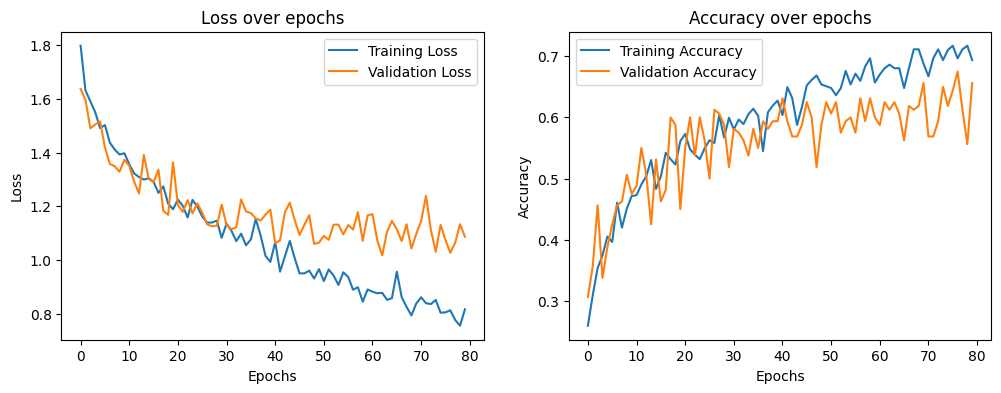

In [7]:
# Rysowanie wykresów dla straty
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Rysowanie wykresów dla dokładności
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [8]:
model.save('v2_65.h5')